## Grader scores

In [1]:
import os
import csv
import numpy as np

from sklearn import metrics
from matplotlib import pylab as plt
import pandas as pd

In [39]:
def se_sp(ref, obs):
    tp = np.sum((ref == 1) & (obs == 1))
    tn = np.sum((ref == 0) & (obs == 0))
    fp = np.sum((ref == 0) & (obs == 1))
    fn = np.sum((ref == 1) & (obs == 0))

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    return sensitivity, specificity, tp, tn, fp, fn

## Load graders scores

In [3]:
grader_folder = '/media/QNAP/People/BartLiefers/ROP/Independent Test/'

#Himanshu Patel - Consultant
#Anne-Marie Hinds - Consultant
#Rob Henderson - Consultant
#Meena Arun - Fellow
#Janette Ravello - Nurse specialist

all_gradings = {}
for grader in 'HP', 'AMH', 'MA', 'RH':
    for grading in 'Normal', 'Plus', 'Pre-Plus':
        folder = '/media/QNAP/People/BartLiefers/ROP/Independent Test/{}/{}'.format(grader, grading)
        if grader == 'RH':
            folder = '/media/QNAP/People/BartLiefers/ROP/Independent Test/{}/ROP AI project/{}'.format(grader, grading)
        for filename in os.listdir(folder):
            if not filename.endswith('.png'):
                 continue
            all_gradings[grader, filename] = grading.lower()
            
df = pd.read_excel('/media/QNAP/People/BartLiefers/ROP/Independent Test/JR/Copy of Ravelo_ROP.xlsx', engine='openpyxl')
for i, row in df.iterrows():
    all_gradings['JR', row.File] = row.Diagnosis.lower()
    
len(all_gradings)

/usr/local/lib/python3.6/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


1000

In [4]:
# these are the files graded by all
test_filenames = list(set(filename for grader, filename in all_gradings))
len(test_filenames)

200

## Other graders plus reference 

In [5]:
#data_folder = '/media/QNAP/People/GongyuZhang/ROP/data/raw/image/'
with open('../src/data/data_split.csv', 'r') as f:
    content = list(csv.reader(f))
    grading_header = content[0]
    grading_data = content[1:]
    
for row in grading_data:
    for grader, grading in zip(grading_header[2:], row[2:]):
        filename = row[0]
        if filename in test_filenames:
            all_gradings[grader, filename] = grading

In [6]:
{grader for grader, fn in all_gradings}

{'AMH', 'CH', 'GA', 'HP', 'JR', 'JT', 'KP', 'MA', 'RH', 'SB', 'group'}

In [7]:
# exclude GA and group
all_observers = 'AMH', 'CH', 'HP', 'JR', 'JT', 'KP', 'MA', 'RH', 'SB'
class_names = 'normal', 'pre-plus', 'plus'

In [8]:
# reference
reference_list = np.array([int(all_gradings['GA', fn] != 'normal') for fn in test_filenames])
reference_index = {filename: grading for filename, grading in zip(test_filenames, reference_list)}

## Majority

In [19]:
graders_full_set = 'GA', 'AMH', 'HP', 'JR', 'MA', 'RH'
from collections import Counter

for fn in test_filenames:
    counts = Counter([all_gradings[grader, fn] for grader in graders_full_set])
    majority, _ = counts.most_common(1)[0]
    all_gradings['majority', fn] = majority

## Load model output

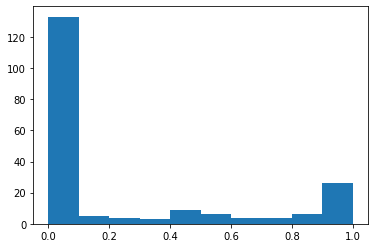

In [61]:
with open('model_classification_all_files.csv', 'r') as f:
    content = list(csv.reader(f))
    model_header = content[0]
    model_data = content[1:]

model_gradings = {}    
for file, model, normal, pre_plus, plus in model_data:
    model_gradings[file, int(model), 'normal'] = float(normal)
    model_gradings[file, int(model), 'pre-plus'] = float(pre_plus)
    model_gradings[file, int(model), 'plus'] = float(plus)
    
# average for each class
for file in test_filenames:
    for class_name in class_names:
        model_gradings[file, class_name] = sum(model_gradings[file, i, class_name] for i in range(5)) / 5
        
ensemble_list = [np.mean([1 - model_gradings[filename, i, 'normal'] for i in range(5)])
    for filename in test_filenames]

ensemble_index = {filename: grading for filename, grading in zip(test_filenames, ensemble_list)}

plt.hist(ensemble_index.values())
plt.show()

## Calibrate
TODO: on validation set?

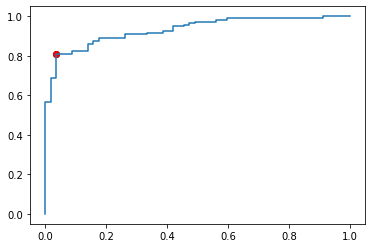

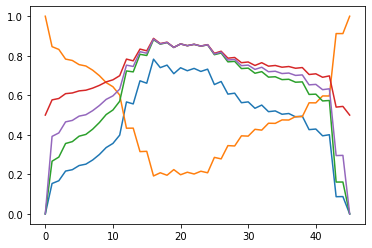

In [22]:
class_name = 'normal'
x = [all_gradings['GA', filename] == class_name for filename in test_filenames]
y = [model_gradings[filename, class_name] for filename in test_filenames]
fpr, tpr, threshold = metrics.roc_curve(x, y)
plt.plot(fpr, tpr)

product = [(1 - fp) * tp for fp, tp in zip(fpr, tpr)]
i = np.argmax(product)
plt.scatter(fpr[i], tpr[i], c='k')

dist_to_corner = [np.sqrt(fp**2 + (1-tp)**2)
                  for fp, tp in zip(fpr, tpr)]
i = np.argmin(dist_to_corner)
plt.scatter(fpr[i], tpr[i], c='r')

harmonic_mean = [(2 * (1-fp)*tp) / ((1-fp) + tp)
                  for fp, tp in zip(fpr, tpr)]

arithmetic_mean = [((1-fp) + tp) / 2
                  for fp, tp in zip(fpr, tpr)]

geometric_mean = [np.sqrt((1-fp)*tp)
                  for fp, tp in zip(fpr, tpr)]

plt.show()
plt.plot(product)
plt.plot(dist_to_corner)
plt.plot(harmonic_mean)
plt.plot(arithmetic_mean)
plt.plot(geometric_mean)

In [23]:
def get_threshold(class_name):
    x = [all_gradings['GA', filename] == class_name for filename in test_filenames]
    y = [model_gradings[filename, class_name] for filename in test_filenames]

    fpr, tpr, threshold = metrics.roc_curve(x, y)
    dist_to_corner = [np.sqrt(fp**2 + (1-tp)**2)
                      for fp, tp in zip(fpr, tpr)]
    i = np.argmin(dist_to_corner)
    return threshold[i]

In [24]:
exponent = {class_name: - np.log(2) / np.log(get_threshold(class_name)) for class_name in class_names}
exponent

{'normal': 55.30459219775056,
 'pre-plus': 0.051615647034298155,
 'plus': 0.43640550494323466}

In [25]:
calibrated_scores = {}
for file in test_filenames:
    calibrated = [model_gradings[file, class_name]**exponent[class_name] for class_name in class_names]
    calibrated_scores[file] = calibrated
    all_gradings['calibrated', file] = class_names[np.argmax(calibrated)]

In [29]:
for file in test_filenames:
    print(file)
    print(all_gradings['majority', file])
    print('original  ', '{:.3f} {:.3f} {:.3f}'.format(* [model_gradings[file, class_name] for class_name in class_names]))
    print('calibrated', '{:.3f} {:.3f} {:.3f}'.format(* [model_gradings[file, class_name]**exponent[class_name] for class_name in class_names]))
    print()

ec129719-ba23-4d4b-a083-bd341620f28e.12.png
normal
original   1.000 0.000 0.000
calibrated 1.000 0.407 0.000

ad77a759-6216-4e1e-95ea-fe89bd381737.36.png
plus
original   0.190 0.000 0.810
calibrated 0.000 0.594 0.912

4e04abb8-f6e8-4694-aa33-4ff576239833.33.png
plus
original   0.173 0.000 0.827
calibrated 0.000 0.553 0.920

5e226e59-e03d-4af2-a9eb-c7ddfec19042.28.png
normal
original   1.000 0.000 0.000
calibrated 1.000 0.360 0.000

d642ce5b-8204-48a6-bffd-e4db7059dee1.17.png
pre-plus
original   0.118 0.000 0.882
calibrated 0.000 0.539 0.947

c186df90-fc74-49b6-8f31-71b15853118e.51.png
normal
original   1.000 0.000 0.000
calibrated 1.000 0.431 0.002

dd921b56-d1ac-4ba6-8fb1-2e54f2e3a407.33.png
plus
original   0.006 0.000 0.994
calibrated 0.000 0.555 0.998

f82a5128-aae5-4b92-8ff3-e234c2214ba9.14.png
plus
original   0.000 0.000 1.000
calibrated 0.000 0.455 1.000

05d01d0d-5d9d-4f73-98ef-f4f9b37418aa.31.png
plus
original   0.000 0.000 1.000
calibrated 0.000 0.459 1.000

022db5f1-3d32-49be

In [40]:
def print_confusion(reference = 'GA', observer = 'calibrated'):
    print('{:>40s}'.format(observer))
    print('{:>18s} {:>8s} {:>8s} {:>8s}'.format('', *class_names))
    for x_class_name in class_names:
        if x_class_name == 'pre-plus':
            print('{:>18s}'.format(reference + ' ' + x_class_name), end=' ')
        else:
            print('{:>18s}'.format(x_class_name), end=' ')
            
        ref = np.array([all_gradings[reference, file] == x_class_name for file in test_filenames])
        for y_class_name in class_names:
            obs = np.array([all_gradings[observer, file] == y_class_name for file in test_filenames])
            print('{:8d}'.format(np.count_nonzero(ref & obs)), end=' ')
        print()
        
    print()
    print('referability (normal vs plus/pre-plus)')
    r = np.array([all_gradings[reference, file] != 'normal' for file in test_filenames])
    o = np.array([all_gradings[observer, file] != 'normal' for file in test_filenames])
    sensitivity, specificity, tp, tn, fp, fn = se_sp(r, o)
    print('sensitivity: {:.3f}'.format(sensitivity))
    print('specificity: {:.3f}'.format(specificity))

In [41]:
print_confusion('GA', 'calibrated')

                              calibrated
                     normal pre-plus     plus
            normal      115       12       16 
       GA pre-plus        2        7        9 
              plus        0        4       35 

referability (normal vs plus/pre-plus)
sensitivity: 0.965
specificity: 0.804


In [42]:
print_confusion('majority', 'calibrated')

                              calibrated
                     normal pre-plus     plus
            normal      109        7        0 
 majority pre-plus        8       13       23 
              plus        0        3       37 

referability (normal vs plus/pre-plus)
sensitivity: 0.905
specificity: 0.940


16 cases that GA classified as normal and the model as plus:
majority considers pre-plus (14) or plus (2)

calibration seems less optimal for majority decision

In [43]:
print_confusion('GA', 'majority')

                                majority
                     normal pre-plus     plus
            normal      115       18       10 
       GA pre-plus        1       16        1 
              plus        0       10       29 

referability (normal vs plus/pre-plus)
sensitivity: 0.982
specificity: 0.804


## Observer scores

In [49]:
def get_se_sp(observer, filenames):
    # only evaluate files with valid grading
    include_filenames = [fn for fn in filenames if all_gradings[observer, fn] in class_names]

    # normal -> 0, plus/pre-plus -> 1
    obs = np.array([int(all_gradings[observer, fn] != 'normal') for fn in include_filenames])
    ref = np.array([reference_index[fn] for fn in include_filenames])
   
    return se_sp(ref, obs) 


In [50]:
print('{:15s} {:>8s} {:>8s} {:>4s} {:>4s} {:>4s} {:>4s} {:>4s}'.format('observer', 'SE', 'SP', 'TP', 'TN', 'FP', 'FN', 'N'))

for observer in all_observers:
    sensitivity, specificity, tp, tn, fp, fn = get_se_sp(observer, test_filenames)
    print('{:15s} {:>8.3f} {:>8.3f} {:>4d} {:>4d} {:>4d} {:>4d} {:>4d}'.format(observer, sensitivity, specificity, tp, tn, fp, fn, sum([tp, tn, fp, fn])))
    

observer              SE       SP   TP   TN   FP   FN    N
AMH                0.965    0.769   55  110   33    2  200
CH                 0.938    0.804   30   45   11    2   88
HP                 0.930    0.783   53  112   31    4  200
JR                 0.947    0.783   54  112   31    3  200
JT                 0.969    0.851   31   57   10    1   99
KP                 1.000    0.370   25   27   46    0   98
MA                 0.965    0.762   55  109   34    2  200
RH                 1.000    0.692   57   99   44    0  200
SB                 0.960    0.551   24   43   35    1  103


## Bootstrap ROC

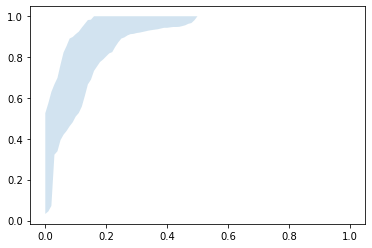

In [51]:
n_bootstraps = 1000
base_fpr = np.linspace(0, 1, 101)


bootstrap_samples = [np.random.choice(test_filenames, size=len(test_filenames), replace=True) for _ in range(n_bootstraps)]

bootstrap_ensemble_list = [[ensemble_index[k] for k in sample] for sample in bootstrap_samples]
bootstrap_reference_list = [[reference_index[k] for k in sample] for sample in bootstrap_samples]


def get_bootstrap_fpr(reference_sample, ensemble_sample):
    fpr, tpr, threshold = metrics.roc_curve(reference_sample, ensemble_sample)
    return np.interp(base_fpr, fpr, tpr)
    
all_fprs = [get_bootstrap_fpr(reference_sample, ensemble_sample)
            for reference_sample, ensemble_sample 
            in zip(bootstrap_reference_list, bootstrap_ensemble_list)]

lower_fpr = np.percentile(all_fprs, 2.5, axis=0)
upper_fpr = np.percentile(all_fprs, 97.5, axis=0)
plt.fill_between(base_fpr, lower_fpr, upper_fpr, alpha=0.2)

In [52]:

def get_error_bar(observer, ci=95):
    d = (100 - ci) / 2 # lower and upper percentiles
    
    se, sp, tp, tn, fp, fn = get_se_sp(observer, test_filenames)
    se_bootstrap, sp_bootstrap, _, _, _, _ = np.array([get_se_sp(observer, sample) for sample in bootstrap_samples]).T
    
    yerr = np.array([[se - np.percentile(se_bootstrap, d)], [np.percentile(se_bootstrap, 100 - d) - se]])
    xerr = np.array([[sp - np.percentile(sp_bootstrap, d)], [np.percentile(sp_bootstrap, 100 - d) - sp]])
    
    return se, sp, xerr, yerr


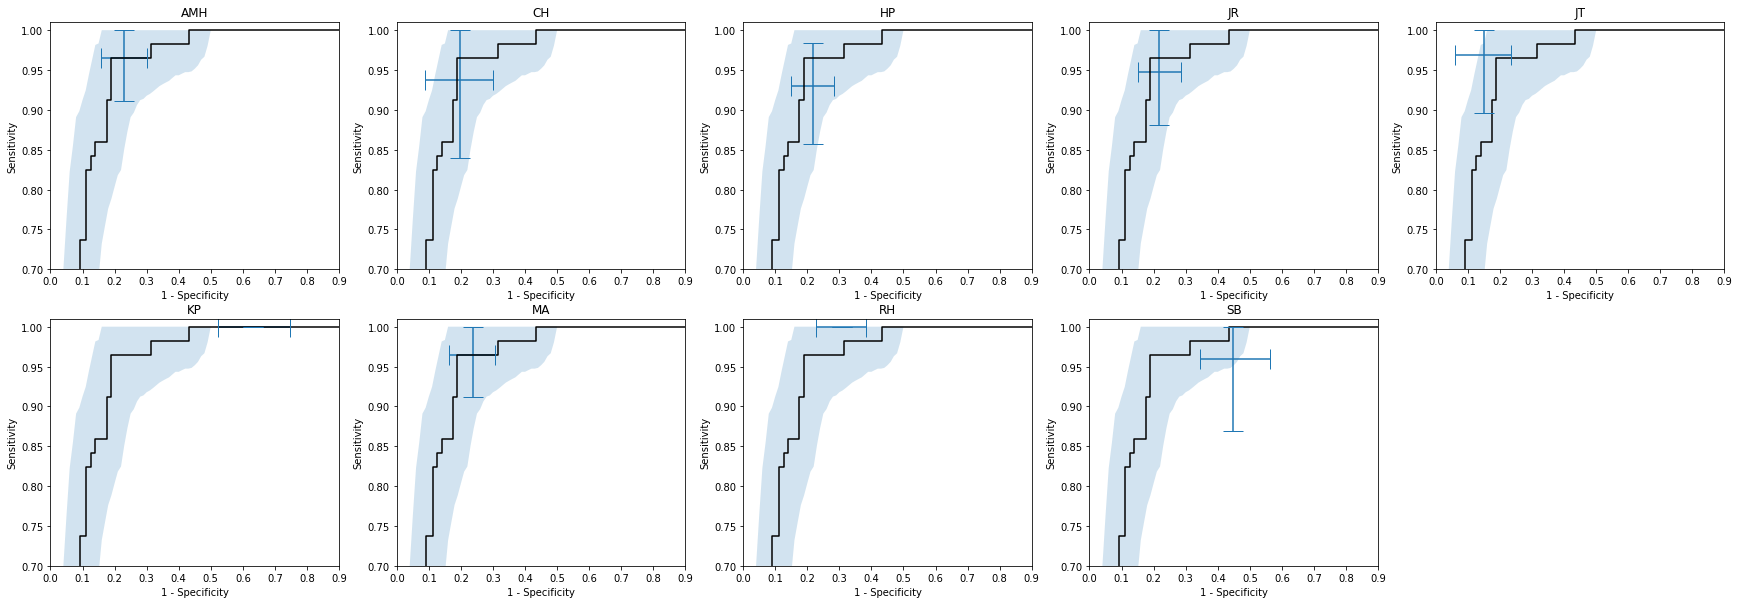

In [57]:
plt.figure(figsize=(30, 10))

for i, observer in enumerate(all_observers):
    ax = plt.subplot(2, 5, i+1)
    
    fpr, tpr, threshold = metrics.roc_curve(reference_list, ensemble_list)
    
    ax.plot(fpr, tpr, label='ensemble', c='k')
    ax.fill_between(base_fpr, lower_fpr, upper_fpr, alpha=0.2)
    
    se, sp, xerr, yerr = get_error_bar(observer)
    ax.errorbar(1 - sp, se, yerr=yerr, xerr=xerr, capsize=10) 

    ax.set_title(observer)
    ax.set_xlabel('1 - Specificity')
    ax.set_ylabel('Sensitivity')
    ax.set_ylim(0.7, 1.01)
    ax.set_xlim(0.0, 0.9)
    

## AUC compared to different reference graders

In [58]:
from sklearn.metrics import roc_auc_score
print('grader   AUC')
o = [ensemble_index[fn] for fn in test_filenames]
for grader in graders_full_set:
    r = [all_gradings[grader, fn] != 'normal' for fn in test_filenames]    
    print('{:8s} {:.3f}'.format(grader, roc_auc_score(r, o)))
print()

r = [all_gradings['majority', fn] != 'normal' for fn in test_filenames]
print('{:8s} {:.3f}'.format('majority', roc_auc_score(r, o)))

grader   AUC
GA       0.932
AMH      0.976
HP       0.963
JR       0.952
MA       0.975
RH       0.954

majority 0.972


## AUC for each class

In [63]:
print('GA')

for class_name in ('normal', 'pre-plus', 'plus'):
    r = [all_gradings['GA', fn] == class_name for fn in test_filenames]
    o = [model_gradings[fn, class_name] for fn in test_filenames]

    print('{:8s} {:.3f}'.format(class_name, roc_auc_score(r, o)))

GA
normal   0.932
pre-plus 0.817
plus     0.941


In [65]:
print('majority')
for class_name in ('normal', 'pre-plus', 'plus'):
    r = [all_gradings['majority', fn] == class_name for fn in test_filenames]
    o = [model_gradings[fn, class_name] for fn in test_filenames]

    print('{:8s} {:.3f}'.format(class_name, roc_auc_score(r, o)))

majority
normal   0.972
pre-plus 0.794
plus     0.942


## Check ambiguous files

In [66]:
unequivocal_filenames = [fn for fn in test_filenames if len({all_gradings[grader, fn] for grader in graders_full_set}) == 1]
ambiguous_filenames = [fn for fn in test_filenames if len({all_gradings[grader, fn] for grader in graders_full_set}) > 1]
len(unequivocal_filenames), len(ambiguous_filenames)

(114, 86)

In [69]:
for fn in ambiguous_filenames:
    print(fn)   
    print('GA:        ', all_gradings['GA', fn])
    
    for class_name in ('normal', 'pre-plus', 'plus'):
        print('{:10s} '.format(class_name), [grader for grader in all_observers if all_gradings[grader, fn] == class_name])
    
    print('calibrated: {:102}'.format(all_gradings['calibrated', fn]))
    print('calibrated: {:.2f} {:.2f} {:.2f}'.format(*calibrated_scores[fn]))
    print('model:      {:.2f}'.format(ensemble_index[fn]))
    print()

4e04abb8-f6e8-4694-aa33-4ff576239833.33.png
GA:         plus
normal      []
pre-plus    ['AMH', 'JR', 'MA']
plus        ['CH', 'HP', 'JT', 'RH']
calibrated: plus                                                                                                  
calibrated: 0.00 0.55 0.92
model:      0.83

d642ce5b-8204-48a6-bffd-e4db7059dee1.17.png
GA:         plus
normal      []
pre-plus    ['AMH', 'HP', 'JR', 'MA']
plus        ['KP', 'RH', 'SB']
calibrated: plus                                                                                                  
calibrated: 0.00 0.54 0.95
model:      0.88

05d01d0d-5d9d-4f73-98ef-f4f9b37418aa.31.png
GA:         normal
normal      []
pre-plus    []
plus        ['AMH', 'CH', 'HP', 'JR', 'JT', 'KP', 'MA', 'RH', 'SB']
calibrated: plus                                                                                                  
calibrated: 0.00 0.46 1.00
model:      1.00

022db5f1-3d32-49be-99e5-55d4fa93a85a.3.png
GA:         normal
normal 

## Cases where everyone disagrees with GA:

```
05d01d0d-5d9d-4f73-98ef-f4f9b37418aa.31.png
GA:         normal
normal      []
pre-plus    []
plus        ['AMH', 'CH', 'HP', 'JR', 'JT', 'KP', 'MA', 'RH', 'SB']
calibrated: plus                                                                                                  
calibrated: 0.00 0.46 1.00
model:      1.00
    
225ef7e2-8600-4da1-847f-2a5be0659bf6.11.png
GA:         normal
normal      []
pre-plus    []
plus        ['AMH', 'CH', 'HP', 'JR', 'JT', 'MA', 'RH']
calibrated: plus                                                                                                  
calibrated: 0.00 0.53 0.80
model:      0.60
    
400050b4-eaac-4950-969f-e86ed150a29d.32.png
GA:         normal
normal      []
pre-plus    []
plus        ['AMH', 'HP', 'JR', 'KP', 'MA', 'RH', 'SB']
calibrated: plus                                                                                                  
calibrated: 0.00 0.60 0.97
model:      0.94

400050b4-eaac-4950-969f-e86ed150a29d.6.png
GA:         normal
normal      []
pre-plus    []
plus        ['AMH', 'CH', 'HP', 'JR', 'JT', 'MA', 'RH']
calibrated: plus                                                                                                  
calibrated: 0.00 0.54 0.66
model:      0.39

91f8a621-37ee-4518-803b-16df1a6d4f04.16.png
GA:         normal
normal      []
pre-plus    ['AMH', 'HP', 'JR', 'KP', 'MA', 'RH', 'SB']
plus        []
calibrated: normal                                                                                                
calibrated: 1.00 0.44 0.01
model:      0.00

145d7193-69fd-4519-95b9-6f1eac00d693.3.png
GA:         normal
normal      []
pre-plus    ['AMH', 'HP', 'JR', 'KP', 'MA', 'RH', 'SB']
plus        []
calibrated: plus                                                                                                  
calibrated: 0.00 0.54 0.83
model:      0.65

fe2fe604-cc5b-4477-bb7b-beb84f8d2cb0.1.png
GA:         plus
normal      []
pre-plus    ['AMH', 'CH', 'HP', 'JR', 'JT', 'MA', 'RH']
plus        []
calibrated: pre-plus                                                                                              
calibrated: 0.01 0.55 0.33
model:      0.08


bc854dfc-559b-4c64-86ba-550d5f240178.15.png
GA:         normal
normal      []
pre-plus    ['AMH', 'HP', 'JR', 'KP', 'MA', 'RH', 'SB']
plus        []
calibrated: plus                                                                                                  
calibrated: 0.00 0.59 0.61
model:      0.32

88c96afe-1004-40db-8aa1-dc20765790a0.15.png
GA:         normal
normal      []
pre-plus    ['AMH', 'HP', 'JR', 'KP', 'MA', 'RH', 'SB']
plus        []
calibrated: pre-plus                                                                                              
calibrated: 0.28 0.53 0.19
model:      0.02

225ef7e2-8600-4da1-847f-2a5be0659bf6.12.png
GA:         pre-plus
normal      []
pre-plus    []
plus        ['AMH', 'CH', 'HP', 'JR', 'JT', 'MA', 'RH']
calibrated: plus                                                                                                  
calibrated: 0.00 0.53 1.00
model:      1.00

9f421e90-c634-4fc6-8eca-909a825f5908.1.png
GA:         plus
normal      []
pre-plus    ['AMH', 'CH', 'HP', 'JR', 'JT', 'MA', 'RH']
plus        []
calibrated: plus                                                                                                  
calibrated: 0.00 0.53 0.56
model:      0.26
```    

## Confusion matrix

In [77]:
def valid(obs, fn):
    return all_gradings[obs, fn] in class_names

all_graders = ('GA', 'calibrated') + all_observers

def get_matrix(class_name, filenames):
    
    n = len(all_graders)
    matrix = np.zeros((n, n))

    for y, obs_y in enumerate(all_graders):
        for x, obs_x in enumerate(all_graders):
            include_filenames = [fn for fn in filenames if valid(obs_y, fn) and valid(obs_x, fn)]
            y_bin = np.array([all_gradings[obs_y, fn] == class_name for fn in include_filenames])
            x_bin = np.array([all_gradings[obs_x, fn] == class_name for fn in include_filenames])

            agreement = np.sum(y_bin==x_bin) / len(include_filenames)
            matrix[y, x] = agreement
            #print('{:0.2f}'.format(agreement), end = ' ')
        #print()
    return matrix
        
def plot_confusion(matrix):
    n = len(all_graders)
    fig = plt.figure(figsize=(15, 15))
    plt.clf()
    ax = fig.add_subplot(111)
    r = ax.imshow(matrix, clim=[0,1])
    for x in range(n):
        for y in range(n):
            ax.annotate('{:0.2f}'.format(matrix[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    ax.set_xticks(range(0, n))
    ax.xaxis.tick_top()
    ax.set_yticks(range(n-1, -1, -1))
    ax.set_xticklabels(all_graders)
    ax.set_yticklabels(all_graders[::-1])
    ax.set_xlim(-0.5, n-0.5)
    ax.set_ylim(n-0.5, -0.5)
    cb = fig.colorbar(r)


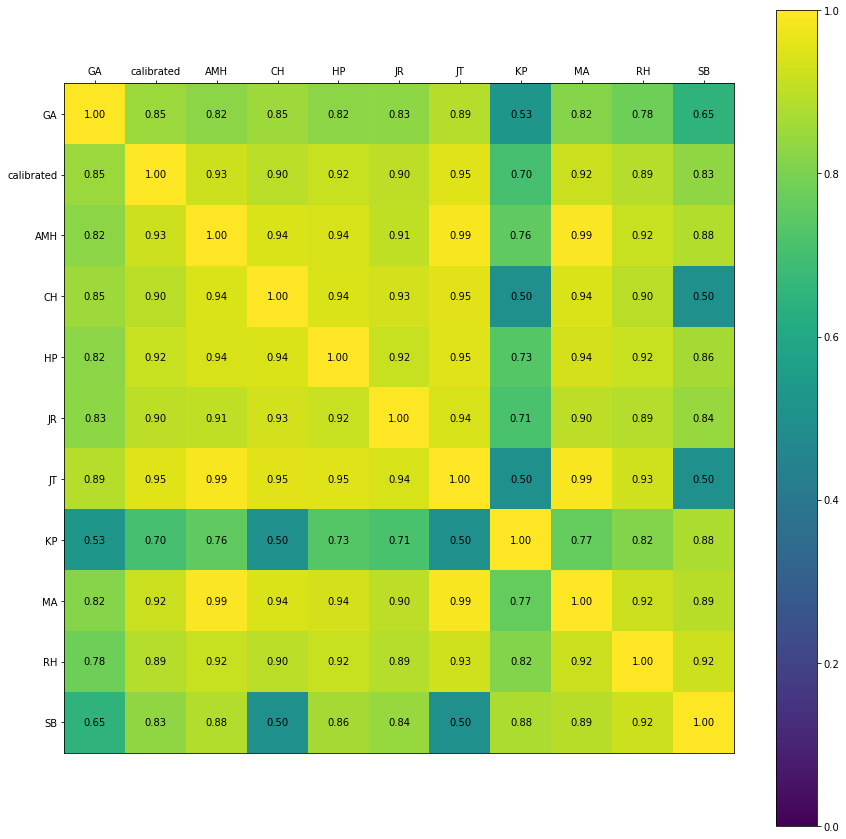

In [78]:
plot_confusion(get_matrix('normal', test_filenames))

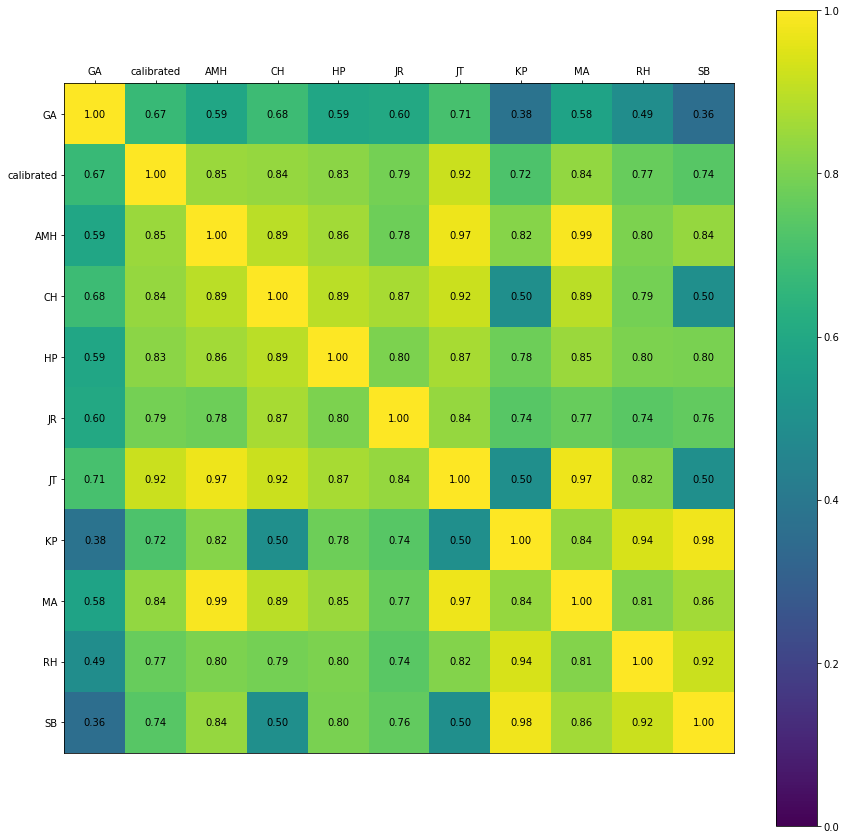

In [79]:
plot_confusion(get_matrix('normal', ambiguous_filenames))

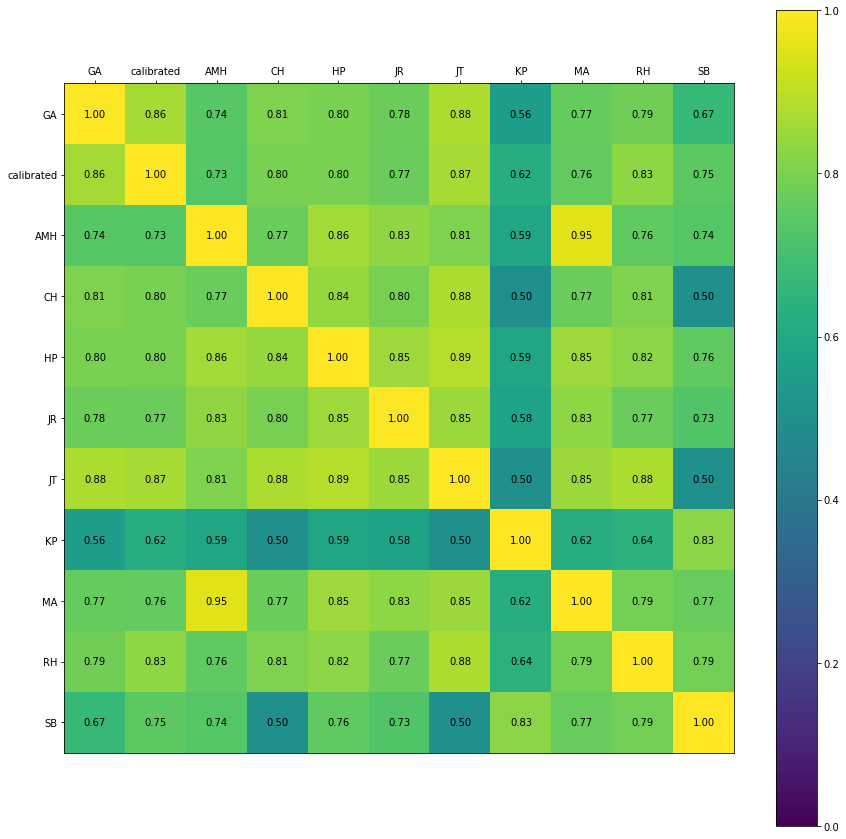

In [80]:
plot_confusion(get_matrix('pre-plus', test_filenames))

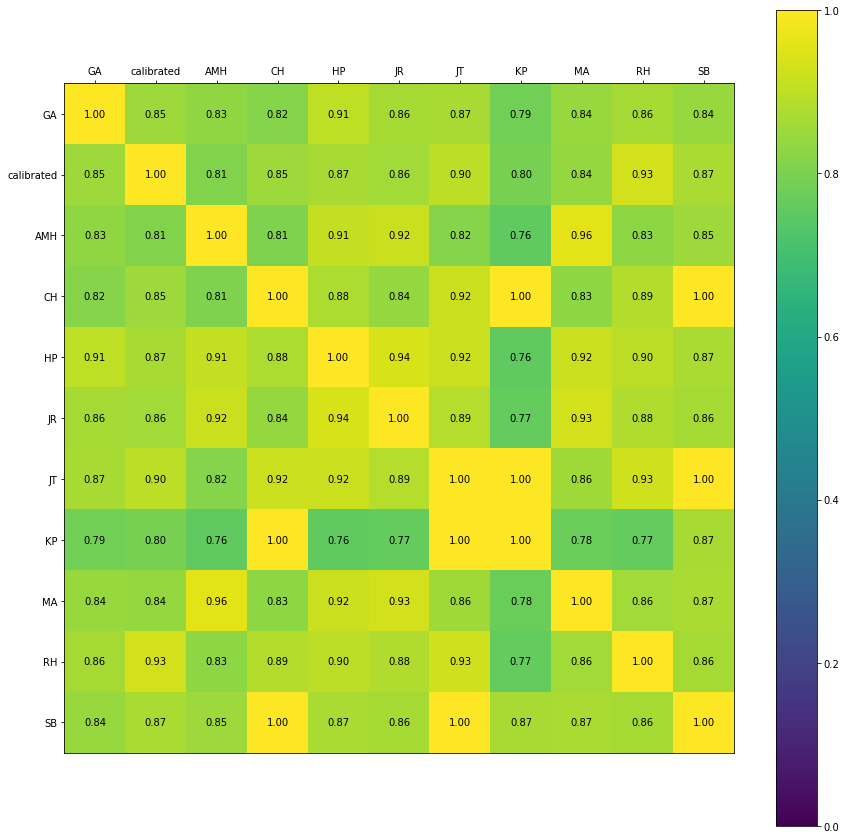

In [81]:
plot_confusion(get_matrix('plus', test_filenames))

## Missing files

In [ ]:
for grader in 'CH', 'SB', 'JT', 'KP':
    missing = [fn for fn in test_filenames if all_gradings[grader, fn] not in ('plus', 'pre-plus', 'normal')]
    print(grader, len(missing))
    with open('missing_{}.csv'.format(grader), 'w') as f:
        csv.writer(f).writerows([[fn] for fn in missing])

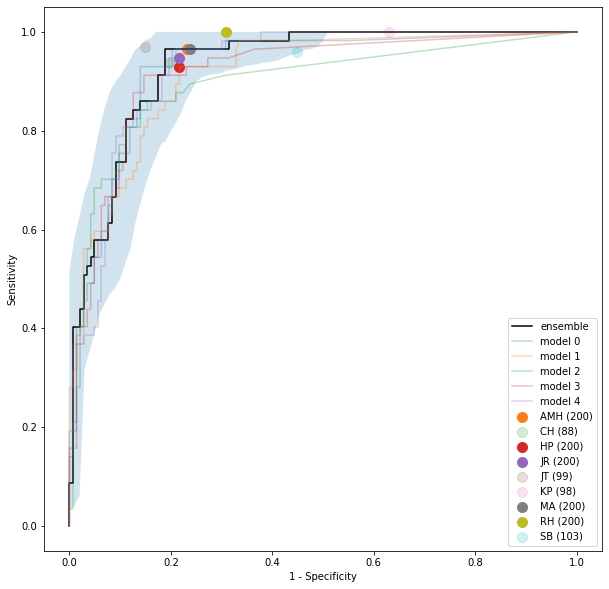

In [45]:

fpr, tpr, threshold = metrics.roc_curve(reference_list, ensemble_list)
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label='ensemble', c='k')
plt.fill_between(base_fpr, lower_fpr, upper_fpr, alpha=0.2)

for i in range(5):
    model_i = [1 - model_gradings[filename, i, 'normal'] for filename in test_filenames]
    
    fpr, tpr, threshold = metrics.roc_curve(reference_list, model_i)
    plt.plot(fpr, tpr, label='model {}'.format(i), alpha=0.3)
    
for observer in all_observers:
    sensitivity, specificity, tp, tn, fp, fn = get_se_sp(observer, test_filenames)
    N = sum([tp, tn, fp, fn])
    alpha = 1 if N == 200 else 0.2
    plt.scatter(1 - specificity, sensitivity, label='{} ({})'.format(observer, N), s=100, alpha=alpha)

plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc='lower right')

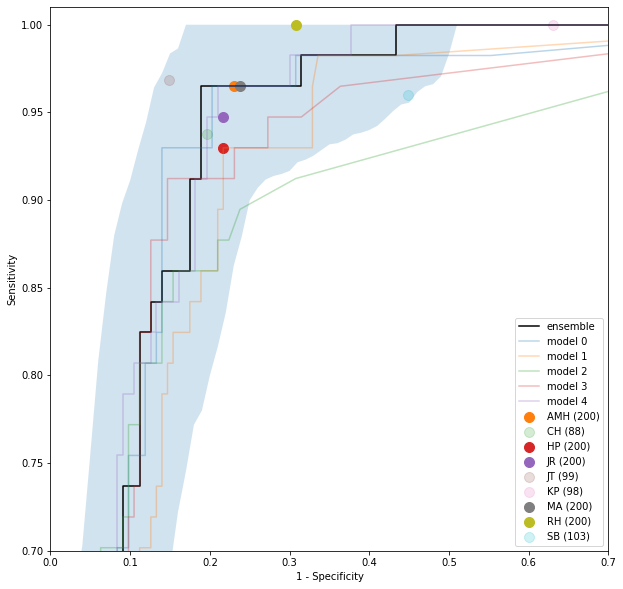

In [46]:

fpr, tpr, threshold = metrics.roc_curve(reference_list, ensemble_list)
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label='ensemble', c='k')
plt.fill_between(base_fpr, lower_fpr, upper_fpr, alpha=0.2)

for i in range(5):
    model_i = [1 - model_gradings[filename, i, 'normal'] for filename in test_filenames]
    
    fpr, tpr, threshold = metrics.roc_curve(reference_list, model_i)
    plt.plot(fpr, tpr, label='model {}'.format(i), alpha=0.3)
    
for observer in all_observers:
    sensitivity, specificity, tp, tn, fp, fn = get_se_sp(observer, test_filenames)
    N = sum([tp, tn, fp, fn])
    alpha = 1 if N == 200 else 0.2
    plt.scatter(1 - specificity, sensitivity, label='{} ({})'.format(observer, N), s=100, alpha=alpha)


plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.ylim(0.7, 1.01)
plt.xlim(0.0, 0.7)
plt.legend(loc='lower right')

In [78]:
from IPython.display import Markdown
import numpy as np

def disp_table(reference_scores, obs_scores):
    table = ''

    
    template = ('| ' + '{:12} | ' * (len(label_names) + 2) + '\n' )
    table += template.format(* (['ref \ model'] + list(label_names) + ['']))
    table += ' :-: '.join(['|'] * (len(label_names) + 3)) + '\n' 
    totals = np.zeros(len(label_names))

    for ref_name in label_names:
        ref_items = reference_scores == ref_name
        c = []
        for obs_name in label_names:
            obs_items = obs_scores == obs_name
            c.append(np.count_nonzero(ref_items & obs_items))

        totals += c
        table += template.format(*([ref_name] + c + [sum(c)]))

    table += template.format(*(['&nbsp;'] + list(totals) + ['']))

    display(Markdown(table))

In [72]:
disp_table(ga_scores, model_scores)

| ref \ model  | normal       | pre-plus     | plus         | ungradable   |              | 
| :-: | :-: | :-: | :-: | :-: | :-: |
| normal       |          132 |            0 |           11 |            0 |          143 | 
| pre-plus     |           13 |            0 |            5 |            0 |           18 | 
| plus         |            9 |            0 |           30 |            0 |           39 | 
| ungradable   |            0 |            0 |            0 |            0 |            0 | 
| &nbsp;       |        154.0 |          0.0 |         46.0 |          0.0 |              | 


In [73]:
disp_table(group_scores, model_scores)

| ref \ model  | normal       | pre-plus     | plus         | ungradable   |              | 
| :-: | :-: | :-: | :-: | :-: | :-: |
| normal       |          100 |            0 |            0 |            0 |          100 | 
| pre-plus     |           41 |            0 |            8 |            0 |           49 | 
| plus         |           13 |            0 |           38 |            0 |           51 | 
| ungradable   |            0 |            0 |            0 |            0 |            0 | 
| &nbsp;       |        154.0 |          0.0 |         46.0 |          0.0 |              | 


In [74]:
disp_table(group_scores, ga_scores)

| ref \ model  | normal       | pre-plus     | plus         | ungradable   |              | 
| :-: | :-: | :-: | :-: | :-: | :-: |
| normal       |          100 |            0 |            0 |            0 |          100 | 
| pre-plus     |           29 |           15 |            5 |            0 |           49 | 
| plus         |           14 |            3 |           34 |            0 |           51 | 
| ungradable   |            0 |            0 |            0 |            0 |            0 | 
| &nbsp;       |        143.0 |         18.0 |         39.0 |          0.0 |              | 
